### Bibliotecas necessárias

In [37]:
import tensorflow as tf
from tensorflow.keras import models,layers,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import keras 
%matplotlib inline
import matplotlib
import mlflow
import mlflow.tensorflow
import mlflow.sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Matplotlib version:", matplotlib.__version__)

TensorFlow version: 2.16.1
Keras version: 3.3.3
Matplotlib version: 3.9.0


### Dataset

In [5]:
# mostrar a quantidade de imagens e classes de treinamento 

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    "../data/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=16 # quantidade de imagens por lote 

)

Found 3286 files belonging to 6 classes.


In [6]:
# mostrar o nome das classes

nomes_classes = dataset.class_names

nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [7]:
# Contar a quantidade de imagens por classe

class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    
    for label in labels:
    
        class_name = dataset.class_names[label]
    
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe

for class_name, count in class_counts.items():

    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes

num_classes = len(dataset.class_names)

print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens

total_images = sum(class_counts.values())

print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe

for class_name, count in class_counts.items():

    percentage = (count / total_images) * 100
    
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 478 imagens
A classe Banana tem 601 imagens
A classe Grape tem 488 imagens
A classe Mango tem 633 imagens
A classe Orange tem 460 imagens
A classe Strawberry tem 626 imagens
Total de classes: 6
Total de imagens: 3286
A classe Apple tem 14.55% das imagens
A classe Banana tem 18.29% das imagens
A classe Grape tem 14.85% das imagens
A classe Mango tem 19.26% das imagens
A classe Orange tem 14.00% das imagens
A classe Strawberry tem 19.05% das imagens


## Distribuição dos dados

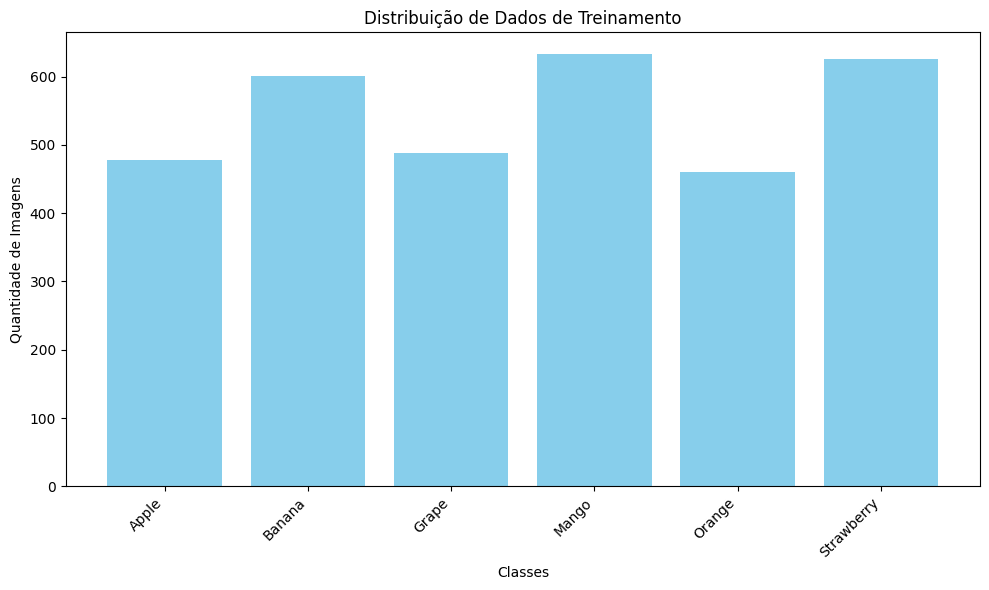

In [28]:
import matplotlib.pyplot as plt

# Exemplo dos dados coletados
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
   
    for label in labels:
   
        class_name = dataset.class_names[label]
   
        class_counts[class_name] += 1

# Dados para plotagem

classes = list(class_counts.keys())

counts = list(class_counts.values())

# Plotando o histograma

plt.figure(figsize=(10, 6))

plt.bar(classes, counts, color='skyblue')

plt.xlabel('Classes')

plt.ylabel('Quantidade de Imagens')

plt.title('Distribuição de Dados de Treinamento')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()


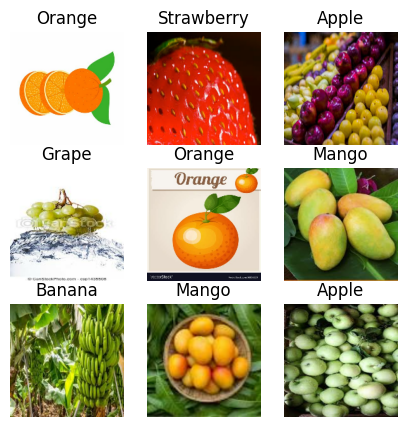

In [29]:
plt.figure(figsize=(5, 5))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

In [35]:
# Parâmetros
image_size = (180, 180)
batch_size = 16 # alterar de 32 para 16 

# Caminhos para os dados de treinamento, validação e teste
treinamento_data = "../data/train"
validacao_data = "../data/valid"
test_data = "../data/test"

# Data Augmentation com Normalização
datagen = ImageDataGenerator(

    rescale=1./255,  # Normalização dos dados

    rotation_range=20,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,
    
    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'
)

train_data_augmented = datagen.flow_from_directory(
    
    treinamento_data,

    target_size=image_size,

    batch_size=batch_size,

    class_mode='sparse'

)

val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(

    validacao_data,

    target_size=image_size,

    batch_size=batch_size,

    class_mode='sparse'

)

test_data = val_datagen.flow_from_directory(

    test_data,

    target_size=image_size,

    batch_size=batch_size,

    class_mode='sparse'
    
)


Found 3286 images belonging to 6 classes.
Found 691 images belonging to 6 classes.
Found 157 images belonging to 6 classes.


In [34]:
# Contar número de imagens e classes
class_names = train_data_augmented.class_indices
num_classes = len(class_names)
num_train_images = train_data_augmented.samples
num_val_images = val_data.samples
num_test_images = test_data.samples

print(f"Número de imagens de treinamento: {num_train_images}")
print(f"Número de imagens de validação: {num_val_images}")
print(f"Número de imagens de teste: {num_test_images}")
print(f"Número de classes: {num_classes}")


Número de imagens de treinamento: 3286
Número de imagens de validação: 691
Número de imagens de teste: 157
Número de classes: 6


## MLflow 

In [12]:
# Definindo o modelo com regularização L2

modelo2 = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3),kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

learning_rate = 1e-4 
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compilando o modelo
modelo2.compile(

    optimizer=adam_optimizer,

    loss='sparse_categorical_crossentropy',

    metrics=['accuracy']

)

# Configurar o MLflow
mlflow.set_tracking_uri("http://localhost:5000")  

mlflow.set_experiment("experimento3")

# Iniciar uma nova execução de MLflow
with mlflow.start_run():

    history = modelo2.fit(

        train_data_augmented,

        epochs=30,

        validation_data = val_data

    )
    
    # Logar parâmetros do modelo
    # Registrar parâmetros
    mlflow.log_param("conv2d_1_filters", 32)
    mlflow.log_param("conv2d_1_kernel_size", (3, 3))
    mlflow.log_param("conv2d_1_activation", 'relu')
    
    mlflow.log_param("conv2d_2_filters", 64)
    mlflow.log_param("conv2d_2_kernel_size", (3, 3))
    mlflow.log_param("conv2d_2_activation", 'relu')
    
    mlflow.log_param("conv2d_3_filters", 128)
    mlflow.log_param("conv2d_3_kernel_size", (3, 3))
    mlflow.log_param("conv2d_3_activation", 'relu')
    
    mlflow.log_param("dense_units", num_classes)
    mlflow.log_param("dense_activation", 'softmax')
    mlflow.log_param("dropout_1", 0.25)
    mlflow.log_param("dropout_2", 0.25)
    mlflow.log_param("optimizer", 'adam')
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("loss_function", 'sparse_categorical_crossentropy')
    
    # Registrar métricas
    for epoch, accuracy in enumerate(history.history['accuracy']):

        mlflow.log_metric("train_accuracy", accuracy, step=epoch)

    for epoch, val_accuracy in enumerate(history.history['val_accuracy']):

        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
    
    # Registrar o modelo
    mlflow.tensorflow.log_model(modelo2, "model")

# Visualizar resultados
print("Modelo treinado e registrado com MLflow.")


Found 3286 images belonging to 6 classes.
Found 691 images belonging to 6 classes.
Found 157 images belonging to 6 classes.
Número de imagens de treinamento: 3286
Número de imagens de validação: 691
Número de imagens de teste: 157
Número de classes: 6
Epoch 1/30


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2330 - loss: 1.7379

c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 121s 555ms/step - accuracy: 0.2335 - loss: 1.7372 - val_accuracy: 0.4038 - val_loss: 1.4711
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 526ms/step - accuracy: 0.4758 - loss: 1.3152 - val_accuracy: 0.4573 - val_loss: 1.3738
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 484ms/step - accuracy: 0.5171 - loss: 1.2202 - val_accuracy: 0.5109 - val_loss: 1.3200
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 498ms/step - accuracy: 0.5346 - loss: 1.2043 - val_accuracy: 0.5137 - val_loss: 1.2520
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 543ms/step - accuracy: 0.5507 - loss: 1.1421 - val_accuracy: 0.5268 - val_loss: 1.2400
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 522ms/step - accuracy: 0.5704 - loss: 1.1170 - val_accuracy: 0.5253 - val_loss: 1.2095
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 467ms/step - accuracy: 0.5680 - loss: 1.1288 - val_accuracy: 0.5514 - val_loss: 1.1637
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 120s 571ms/step - accuracy: 0.5872 - loss: 1.088

2024/07/31 14:28:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modelo treinado e registrado com MLflow.


### Salvar modelo 

In [10]:
with open('../models/history3.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [11]:
import os

file_path = '../models/history3.pkl'

# Verifique se o arquivo existe e não está vazio
if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
        print(history)
else:
    print("O arquivo está vazio ou não existe.")


{'accuracy': [0.3742258846759796, 0.5228546261787415, 0.5499852299690247, 0.574461817741394, 0.582129180431366, 0.5809495449066162, 0.6004128456115723, 0.6021822690963745, 0.6107342839241028, 0.6275435090065002, 0.6299026608467102, 0.6337363719940186, 0.6446475982666016, 0.6455323100090027, 0.6588026881217957, 0.651725172996521, 0.6596873998641968, 0.6570333242416382, 0.6767914891242981, 0.6950752139091492], 'loss': [1.550754427909851, 1.2400239706039429, 1.182465672492981, 1.119127631187439, 1.10817551612854, 1.1016021966934204, 1.0690293312072754, 1.051135778427124, 1.033301591873169, 1.0241544246673584, 1.00887131690979, 1.0073583126068115, 0.9938041567802429, 0.996281087398529, 0.9674299955368042, 0.96528160572052, 0.9488656520843506, 0.9504257440567017, 0.9049804210662842, 0.8970938324928284], 'val_accuracy': [0.3256150484085083, 0.5079594850540161, 0.4920405149459839, 0.4399421215057373, 0.5180897116661072, 0.5701881051063538, 0.4819102883338928, 0.5340086817741394, 0.57597684860

In [12]:

modelo2.save('../models/modelo_cnn.h5')

### Resultados 

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

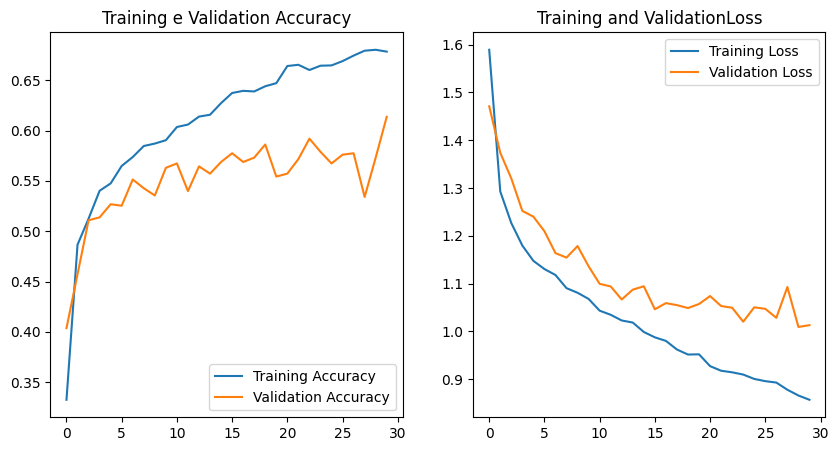

In [17]:
epochs_range = range(30)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training e Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and ValidationLoss')

plt.show()

A partir da visualização dos gráficos a precisão dos dados de treinamento e de validação durante as 30 epochs há a percepção que durante o treinamento, o modelo não se adaptou tão bem para o conjunto de validação.

In [16]:
# avaliar o modelo

train_loss, train_acc = modelo2.evaluate(train_data_augmented, verbose=2)

print('\nTraining accuracy:', train_acc)

print('\nTraining loss:', train_loss)

106/106 - 48s - 457ms/step - accuracy: 0.7086 - loss: 0.8761

Training accuracy: 0.7086405158042908

Training loss: 0.8760590553283691


In [45]:
# Avaliando o modelo no conjunto de validação

val_loss, val_accuracy = modelo2.evaluate(val_data)

print(f'Validação - Perda: {val_loss}, Acurácia: {val_accuracy}')


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5316 - loss: 1.2812

c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.5389 - loss: 1.2729
Validação - Perda: 1.267978549003601, Acurácia: 0.5571635365486145


In [17]:
# Avaliando o modelo no conjunto de teste

val_loss, val_acc = modelo2.evaluate(val_data, verbose=2)

print('\nTest accuracy:', val_acc)

print('\nTest loss:', val_loss)


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 - 4s - 177ms/step - accuracy: 0.5615 - loss: 1.2316

Test accuracy: 0.5615050792694092

Test loss: 1.2316101789474487


In [18]:
# Avaliando o modelo no conjunto de teste

test_loss, test_acc = modelo2.evaluate(test_data, verbose=2)

print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 - 1s - 239ms/step - accuracy: 0.4713 - loss: 2.9778

Test accuracy: 0.47133758664131165

Test loss: 2.9778053760528564


In [23]:
validacao_data = "../data/valid"

val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(
    validacao_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
        shuffle=False

)

Found 691 images belonging to 6 classes.


### Matriz de confusão

Found 691 images belonging to 6 classes.
 2/44 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step 

c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/44 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step

c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step


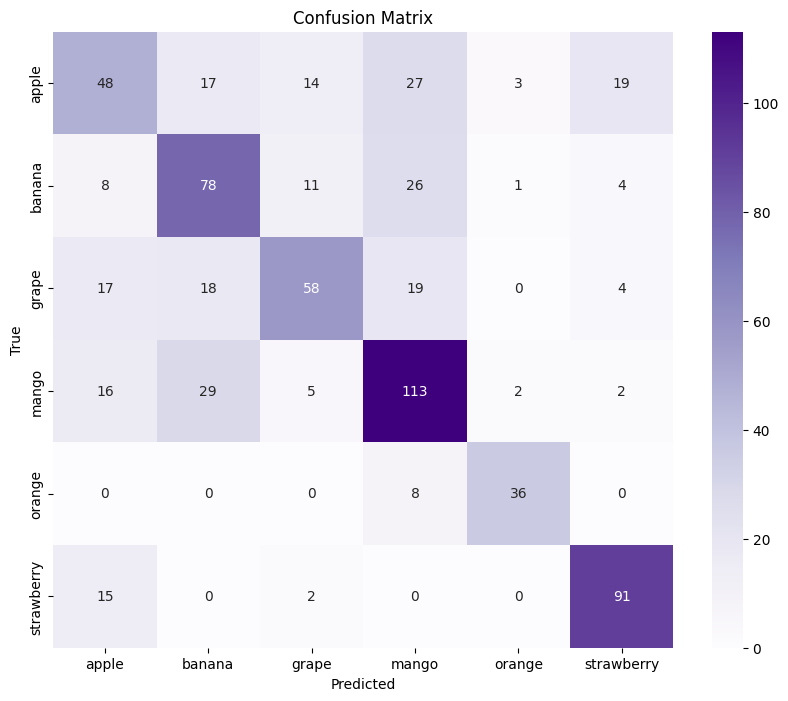

Classification Report:
              precision    recall  f1-score   support

       apple       0.46      0.38      0.41       128
      banana       0.55      0.61      0.58       128
       grape       0.64      0.50      0.56       116
       mango       0.59      0.68      0.63       167
      orange       0.86      0.82      0.84        44
  strawberry       0.76      0.84      0.80       108

    accuracy                           0.61       691
   macro avg       0.64      0.64      0.64       691
weighted avg       0.61      0.61      0.61       691



In [27]:
# Definindo manualmente os nomes das classes (substitua com suas classes reais)
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Configurações do gerador de dados de validação
validacao_data = "../data/valid"

val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(
    validacao_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
        shuffle=False

)
# Fazendo previsões no conjunto de teste
y_pred = modelo2.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtendo os rótulos reais do conjunto de teste
y_true = val_data.classes

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)
